Vaccination data is [here](https://covid.cdc.gov/covid-data-tracker/#vaccinations_vacc-total-admin-rate-total) and ICU data [here](https://coronavirus.jhu.edu/data/hospitalization-7-day-trend). The latter dataset is uploaded [here](https://github.com/RInterested/DATASETS/blob/gh-pages/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries.csv). [This](https://stats.stackexchange.com/a/26779/67822) is what I intend to do.

In [100]:
install.packages('RCurl')
require(RCurl)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Collecting the number of ICU and IP beds dedicated to COVID confirmed or suspected cases per state as a measure of serious disease:

In [101]:
url <- "https://raw.githubusercontent.com/RInterested/DATASETS/gh-pages/COVID19%20Reported%20Patient%20Impact%20and%20Hospital%20Capacity%20by%20State%20Timeseries"
dat <- read.csv(url)
# 13: ""inpatient_beds_used"  "
# 27: "staffed_icu_adult_patients_confirmed_and_suspected_covid"
# 31:"total_adult_patients_hospitalized_confirmed_and_suspected_covid" 
# 39 ""total_staffed_adult_icu_beds"   
data <- dat[,c(1,2,27,39,31,13)]
colnames(data) <- c('state','date','ICUpos','ICUb','IPpos','IPb')
data[,2] <- as.Date(data$date)
df <- data[!(rowSums(is.na(data))),]
df$ICUneg <- df[,4]-df[,3]
df$IPneg  <- df[,6]-df[,5]
df <- df[,c('state','date','ICUpos','ICUneg','ICUb','IPpos','IPneg','IPb')]
df <- df[order(df[,'state']), ]

# Adding IP's and ICU:
df$TOTpos <- df$ICUpos + df$IPpos
df$TOTneg <- df$ICUneg + df$IPneg
df$TOTb   <- df$ICUb + df$IPb
head(df)

,state,date,ICUpos,ICUneg,ICUb,IPpos,IPneg,IPb,TOTpos,TOTneg,TOTb
,<chr>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
73,AK,2020-07-29,11,32,43,51,1031,1082,62,1063,1125
381,AK,2020-08-29,9,37,46,36,826,862,45,863,908
393,AK,2020-12-20,20,106,126,106,856,962,126,962,1088
409,AK,2020-12-04,33,98,131,161,849,1010,194,947,1141
459,AK,2021-01-10,11,107,118,68,810,878,79,917,996
681,AK,2020-12-30,11,116,127,71,838,909,82,954,1036


Now the data in the last 30 days of delta wave (terminating at the beginning of September 2021) in the US will be averaged state-wise. For example:

In [102]:
# Example Alabama:
n <- 30 # number of days to average
AL <- df[df$state=="AL",]
AL <- AL[order(as.Date(AL$date,format = "%d/%m/%Y")),]
row.names(AL) <- 1:nrow(AL)
round(colMeans(tail(AL[,c(3,4,5)],n)))
round(colMeans(tail(AL[,c(6,7,8)],n)))
round(colMeans(tail(AL[,c(9,10,11)],n)))

ICUpos ICUneg   ICUb 
   836    745   1581

IPpos IPneg   IPb 
 2873  9233 12106

TOTpos TOTneg   TOTb 
  3710   9978  13688

Performing the same averaging for all states:

In [103]:
states <- unique(df[,1])
m <- matrix(0,length(states),9)

for(i in 1:length(states)){
  temp <- df[df$state==states[i],]
  temp <- temp[order(as.Date(temp$date,format = "%d/%m/%Y")),]
  m[i,1:9] <- round(colMeans(tail(temp[,3:11],n)))
}
hosp <- cbind.data.frame(states,m)
hosp <- hosp[order(hosp[,'states']), ]
names(hosp) <- names(df)[c(1,3:11)]
hosp$Proportion <- hosp$TOTpos/(hosp$TOTneg+hosp$TOTpos)

Since the vaccines are per 100k in the population (see below) they are independent of the size of the state. Therefore the number of beds in each category should also be standardized to erase differences in population between states:

In [104]:
# Standardization of number of positive and negative beds as though all states were the same size:

icu.beds <- 10^ceiling(log10(max(hosp$ICUpos + hosp$ICUneg)))

hosp$stICUpos <- round(icu.beds * hosp$ICUpos / (hosp$ICUpos + hosp$ICUneg))
hosp$stICUneg <- round(icu.beds * hosp$ICUneg / (hosp$ICUpos + hosp$ICUneg))


ip.beds <- 10^ceiling(log10(max(hosp$IPpos + hosp$IPneg)))

hosp$stIPpos <- round(ip.beds * hosp$IPpos / (hosp$IPpos + hosp$IPneg))
hosp$stIPneg <- round(ip.beds * hosp$IPneg / (hosp$IPpos + hosp$IPneg))


tot.beds <- 10^ceiling(log10(max(hosp$TOTb)))

hosp$stTOTpos <- round(tot.beds * hosp$TOTpos / (hosp$TOTpos + hosp$TOTneg))
hosp$stTOTneg <- round(tot.beds * hosp$TOTneg / (hosp$TOTpos + hosp$TOTneg))

In [105]:
head(hosp)

,state,ICUpos,ICUneg,ICUb,IPpos,IPneg,IPb,TOTpos,TOTneg,TOTb,Proportion,stICUpos,stICUneg,stIPpos,stIPneg,stTOTpos,stTOTneg
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AK,35,89,123,152,931,1082,186,1019,1206,0.1543568,2823,7177,14035,85965,15436,84564
2,AL,836,745,1581,2873,9233,12106,3710,9978,13688,0.2710403,5288,4712,23732,76268,27104,72896
3,AR,457,547,1004,1307,5394,6701,1764,5941,7705,0.2289422,4552,5448,19505,80495,22894,77106
4,AS,0,7,7,0,75,75,0,82,82,0.0000000,0,10000,0,100000,0,100000
5,AZ,478,1689,2167,1966,10277,12243,2444,11966,14410,0.1696044,2206,7794,16058,83942,16960,83040
6,CA,1935,5304,7240,8115,42998,51114,10051,48303,58353,0.1722418,2673,7327,15877,84123,17224,82776


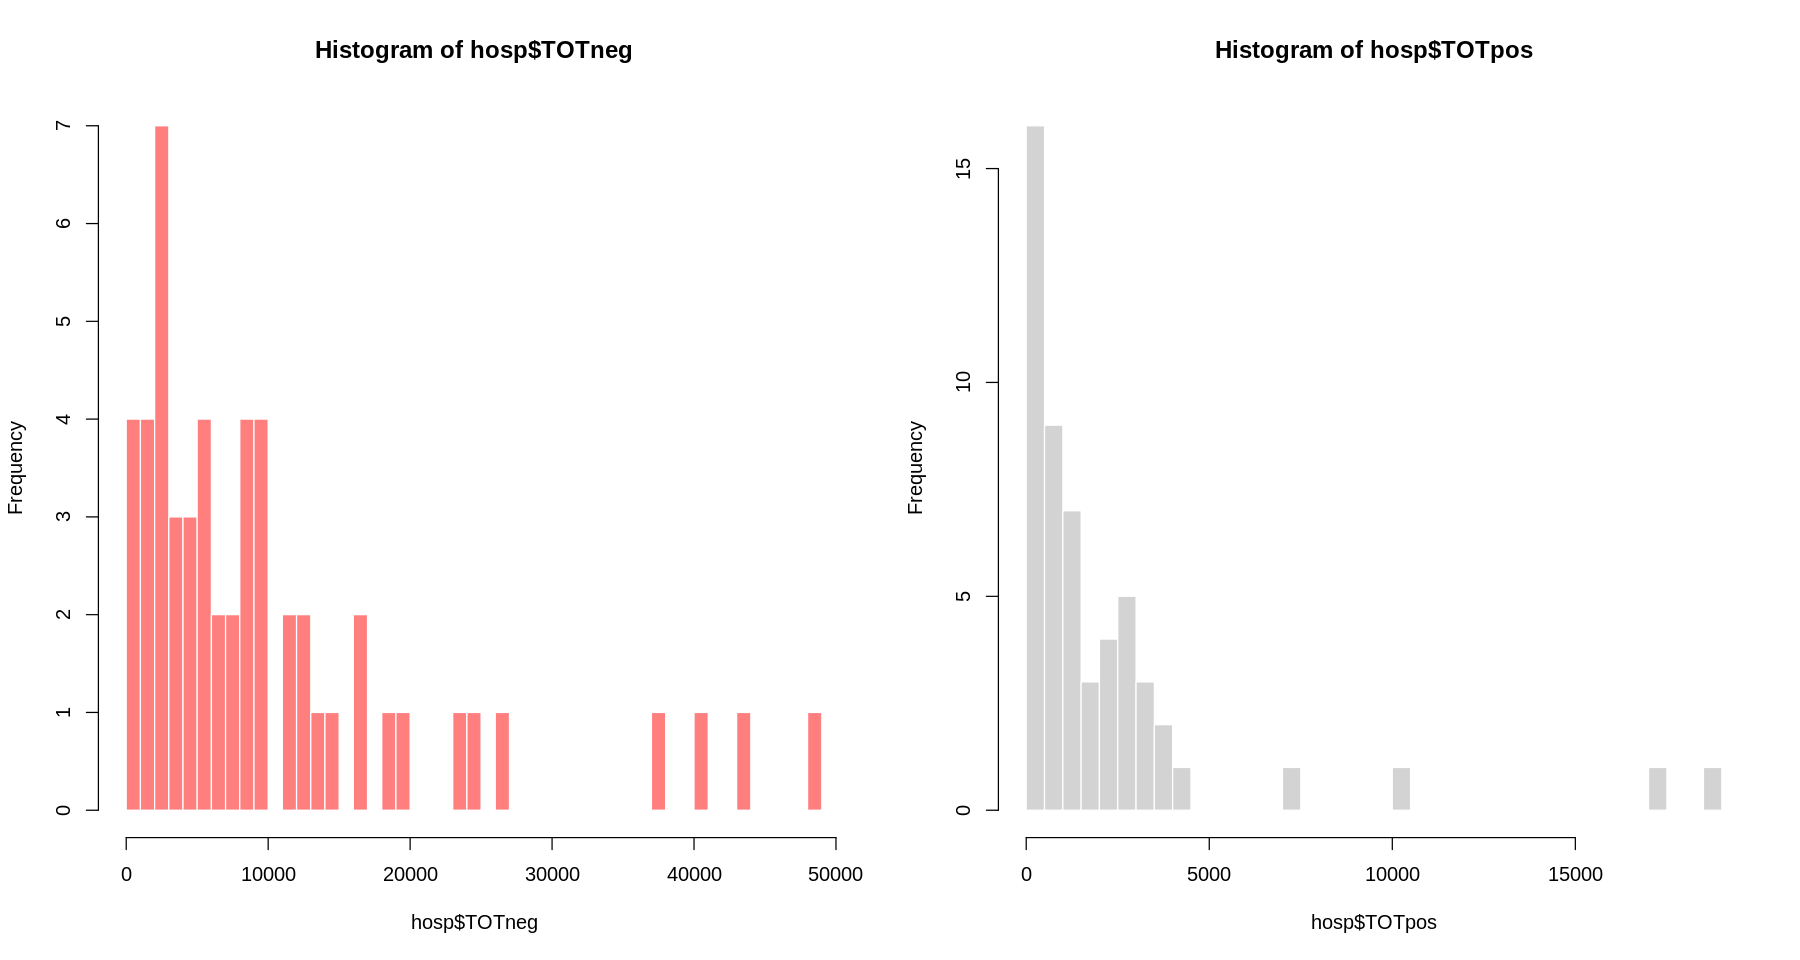

In [106]:
options(repr.plot.width=15, repr.plot.height=8)
par(mfrow=c(1,2))
hist(hosp$TOTneg, breaks=nrow(hosp), col=rgb(1,0,0,.5), border=F)
hist(hosp$TOTpos, breaks=nrow(hosp),  border=F)

In [107]:
summary(hosp$TOTpos)
sd(hosp$TOTpos)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   441.8  1123.0  2226.5  2554.5 18799.0 

[1] 3610.283

Getting the vaccination data per state and tidying up the dataset:

In [108]:
y = url("https://raw.githubusercontent.com/RInterested/DATASETS/gh-pages/covid19_vaccinations_in_the_united_states.csv")
vaccines <- read.csv(y)
vac <- vaccines[,c(1,3)]
# 3: Doses Delivered per 100K
names(vac) <- c('state','jabsx100k')

s = url("https://raw.githubusercontent.com/RInterested/DATASETS/gh-pages/states.csv")
abbr <- read.csv(s)

vac <- vac[vac[,1] %in% abbr[,1],]

for(i in 1:nrow(vac)){
    vac[i,1] <- abbr[which(abbr[,1]==vac[i,1]),2]
}

vac[,2] <- as.numeric(vac[,2])

d <- merge(hosp,vac, by="state")
d$jabsperperson <- d$jabsx100k/10^5
head(d)

,state,ICUpos,ICUneg,ICUb,IPpos,IPneg,IPb,TOTpos,TOTneg,TOTb,Proportion,stICUpos,stICUneg,stIPpos,stIPneg,stTOTpos,stTOTneg,jabsx100k,jabsperperson
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AK,35,89,123,152,931,1082,186,1019,1206,0.1543568,2823,7177,14035,85965,15436,84564,135083,1.35083
2,AR,457,547,1004,1307,5394,6701,1764,5941,7705,0.2289422,4552,5448,19505,80495,22894,77106,127641,1.27641
3,AS,0,7,7,0,75,75,0,82,82,0.0000000,0,10000,0,100000,0,100000,111404,1.11404
4,AZ,478,1689,2167,1966,10277,12243,2444,11966,14410,0.1696044,2206,7794,16058,83942,16960,83040,131204,1.31204
5,CA,1935,5304,7240,8115,42998,51114,10051,48303,58353,0.1722418,2673,7327,15877,84123,17224,82776,142990,1.42990
6,CO,273,1079,1353,777,7224,8002,1051,8304,9354,0.1123463,2019,7981,9711,90289,11235,88765,137594,1.37594


Checking whether the logistic regression of covid cases in the ICU and in the hospital (total ICU and IP) regressed over the vaccination status of the population in different states is significant:

A binomial response variable is measured as a count of binary events (yes or no) out of a
total number of observations. The binomial denominator m does not need to be the same
for every sample, but it must be known.
This is different from a continuous proportion, which is the ratio of 2 continuous
variables. For example, the proportion of fat per unit of weight in ants; the proportion of
water by weight in leaves, etc… Continuous proportions do not have a binomial
distribution. Continuous proportions as response variables must be handled with least
squares regression (e.g., ANOVA, linear regression, multiple regression).
Example: We investigate the number of bird species that got extinct on 18 islands during
a 10-year period. Species were monitored on each island in 1949. All the species present
were considered “at risk”. Presence / absence was monitored again 10 years later:
species that were no longer present were considered “extinct”. The response variable for
each islands takes this form: # extinct / # at risk. 

In [109]:
fit <- glm(cbind(d$ICUpos,d$ICUneg) ~ scale(d$jabsx100k), 
           family='binomial')
summary(fit)
exp(cbind(OR = coef(fit), confint(fit))) # The coeff's are the result of the linear part. Exp(coeff's) = ODDS RATIOS.


Call:
glm(formula = cbind(d$ICUpos, d$ICUneg) ~ scale(d$jabsx100k), 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-27.566   -7.525   -2.758    2.623   39.715  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.871522   0.007831 -111.30   <2e-16 ***
scale(d$jabsx100k) -0.193593   0.010832  -17.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8346.2  on 51  degrees of freedom
Residual deviance: 8024.5  on 50  degrees of freedom
AIC: 8375.2

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.4183142,0.4119365,0.4247772
scale(d$jabsx100k),0.8239930,0.8066747,0.8416660


Intercept: The odds of being a covid positive patient in the ICU if zero vaccinations is 42%. The intercept is statistically significant $\implies \neq 0.$ The intercept in a logistic model can be interpreted as the "baseline risk or odds".

Slope: A $1$ SD increase in the vaccination status of the state, decreases 20% the odds of being in the ICU.

The scaling and centering is meant to estimate the effect size. From [here](https://www.theanalysisfactor.com/effect-size-statistics-logistic-regression/):

*For example, let’s say you’re doing a logistic regression for a ecology study on whether or not a wetland in a certain area has been infected with a specific invasive plant.  Predictors include water temperature in degrees Celsius, altitude, and whether the wetland is a fen or a marsh.*

*If the odds ratio for water temperature is 1.12, that means that for each one-degree Celsius increase in water temperature, the odds of the wetland having the invasive plant species is 1.12 times as big, after controlling for the other predictors.*

*That odds ratio is an unstandardized effect size statistic.  It tells you the direction and the strength of the relationship between water temperature and the odds that the plant is present.*

*It’s unstandardized because it’s based on the units of temperature.**

I realize no ecologist would do so, but if the water were measured in degrees Fahrenheit, that odds ratio would have a different value.  The direction and the strength of the relationship would be the same, but the statistic would be evaluated on a different scale* 

With the standardized data (per 10K ICU beds):

In [110]:
fit.st <- glm(cbind(d$stICUpos,d$stICUneg) ~ scale(d$jabsx100k), 
           family='binomial')
summary(fit.st)
exp(cbind(OR = coef(fit.st), confint(fit.st)))


Call:
glm(formula = cbind(d$stICUpos, d$stICUneg) ~ scale(d$jabsx100k), 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-87.995  -21.500   -7.939   18.689   59.741  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.095414   0.003228 -339.35   <2e-16 ***
scale(d$jabsx100k) -0.238786   0.003314  -72.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 48531  on 51  degrees of freedom
Residual deviance: 43214  on 50  degrees of freedom
AIC: 43690

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.3344010,0.3322908,0.3365222
scale(d$jabsx100k),0.7875834,0.7824816,0.7927144


The results are slightly different.

And without scaling the DV:

In [111]:
fit.stan <- glm(cbind(d$stICUpos,d$stICUneg) ~ d$jabsx100k, 
           family='binomial')
summary(fit.stan)
exp(cbind(OR = coef(fit.stan), confint(fit.stan)))


Call:
glm(formula = cbind(d$stICUpos, d$stICUneg) ~ d$jabsx100k, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-87.995  -21.500   -7.939   18.689   59.741  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  9.427e-01  2.809e-02   33.56   <2e-16 ***
d$jabsx100k -1.519e-05  2.108e-07  -72.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 48531  on 51  degrees of freedom
Residual deviance: 43214  on 50  degrees of freedom
AIC: 43690

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),2.5669687,2.4294799,2.7122995
d$jabsx100k,0.9999848,0.9999844,0.9999852


In [112]:
# Why do I get this insanely small coefficient:
summary(d$jabsperperson)
summary(d$jabsx100k)
# OK... The jabs per 100K is so large that it requires a tiny coefficient!
# When exponentiating something so close to zero: e^0 = 1.
# I guess I could log transform, or simply use jabs per person!

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.032   1.221   1.313   1.342   1.464   1.679 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 103172  122066  131255  134208  146433  167941 

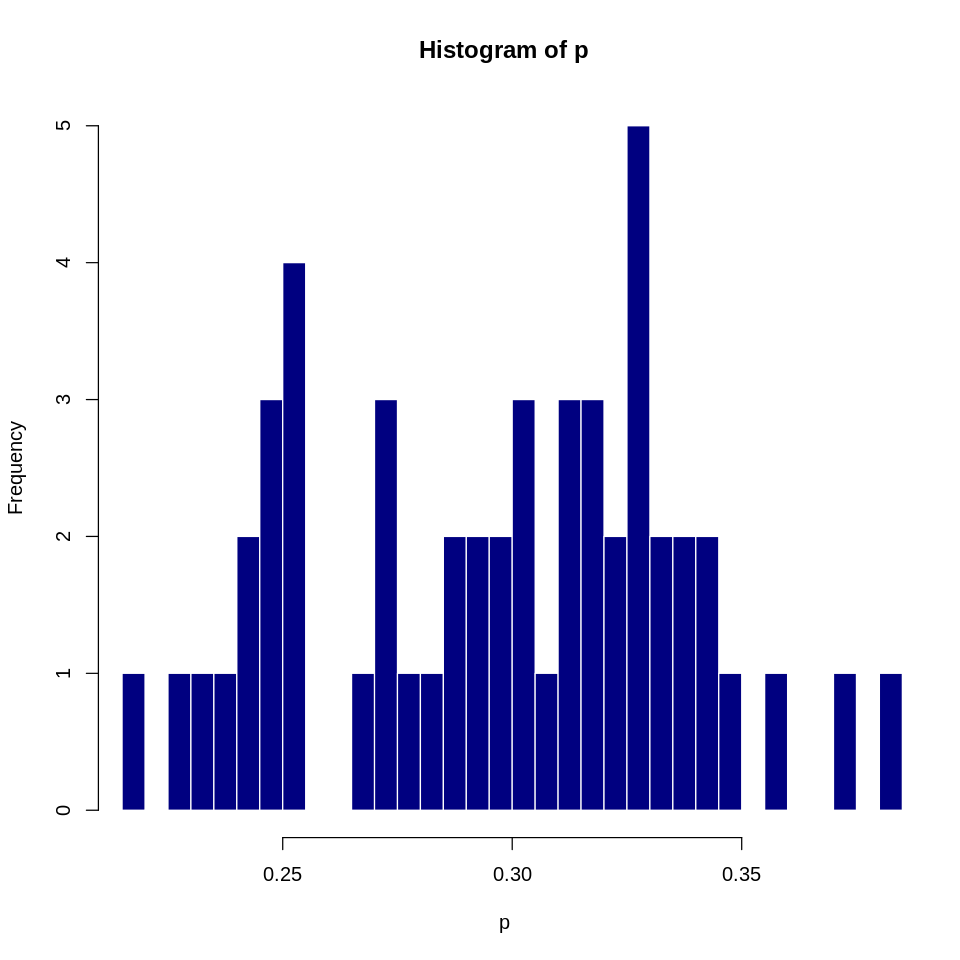

In [113]:
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow=c(1,1))
p <- predict(fit, type="response") # Probability of having a COVID + admitted based on the model
hist(p, breaks=nrow(d), border=F, col='navyblue', xlim=c(min(p),max(p))) 

In [114]:
# Without scaling the regressor and doing it for each individual:
mod <- glm(cbind(d$ICUpos,d$ICUneg) ~ d$jabsperperson, 
           family='binomial')
exp(cbind(OR = coef(fit), confint(fit)))

Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.4183142,0.4119365,0.4247772
scale(d$jabsx100k),0.8239930,0.8066747,0.8416660


1 extra shot per person decreases the odds of ending up in the ICU 18%.

There is a $20$ percent decrease in the odds of ending up in the ICU for extra jab per person (e.g. two doses)! $$\text{OR} =\left( e^{\beta_{\text{jab}}} \right)^{\Delta}$$

A 1 per 100,000 increase doesn't decrease the odds of ending in the ICU more than 0.002 percent.

CHECK WHAT HAPPENS WITH "STANDARDIZED" DATA of 10K ICU beds and jabs/person:

In [115]:
# With standardized data:

mod2 <- glm(cbind(d$stICUpos,d$stICUneg) ~ d$jabsperperson, 
           family='binomial')
summary(mod2)
exp(cbind(OR = coef(mod2), confint(mod2)))


Call:
glm(formula = cbind(d$stICUpos, d$stICUneg) ~ d$jabsperperson, 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-87.995  -21.500   -7.939   18.689   59.741  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.94273    0.02809   33.56   <2e-16 ***
d$jabsperperson -1.51864    0.02108  -72.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 48531  on 51  degrees of freedom
Residual deviance: 43214  on 50  degrees of freedom
AIC: 43690

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),2.5669687,2.4294799,2.7122995
d$jabsperperson,0.2190089,0.2101414,0.2282432


This would imply a whopping 80 percent reduction in the odds of ending in the ICU per increase of one jab per individual!

In [99]:
# Reality check...

mod3 <- glm(cbind(d$stICUpos,d$stICUneg) ~ scale(d$jabsperperson), 
           family='binomial')
summary(mod3)
exp(cbind(OR = coef(mod3), confint(mod3)))

summary(d$jabsperperson)


Call:
glm(formula = cbind(d$stICUpos, d$stICUneg) ~ scale(d$jabsperperson), 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-87.995  -21.500   -7.939   18.689   59.741  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -1.095414   0.003228 -339.35   <2e-16 ***
scale(d$jabsperperson) -0.238786   0.003314  -72.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 48531  on 51  degrees of freedom
Residual deviance: 43214  on 50  degrees of freedom
AIC: 43690

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.3344010,0.3322908,0.3365222
scale(d$jabsperperson),0.7875834,0.7824816,0.7927144


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.032   1.221   1.313   1.342   1.464   1.679 

In [140]:
# What is 1 SD above the mean?

sd(d$jabsperperson) + mean(d$jabsperperson)

[1] 1.499316

In [147]:
paste('But the rage of non-scaled values is, ', max(d$jabsperperson) - min(d$jabsperperson),'.')

paste("Therefore the odds of being in the ICU with covid will plummet when getting the odds ratio of + 1 in the raw data!")
paste("But not so much with an increase of 1 SD.")
paste("Still we can see that the odds do plummet 80 percent if everyone got from a single to a double shot (?), or better, from 0 to 1 shots.")
paste("So it is necessary to make sure that a + 1 increase in the dependent variable makes sense to consider.")

[1] "But the rage of non-scaled values is,  0.64769 ."

[1] "Therefore the odds of being in the ICU with covid will plummet when getting the odds ratio of + 1 in the raw data!"

[1] "But not so much with an increase of 1 SD."

[1] "Still we can see that the odds do plummet 80 percent if everyone got from a single to a double shot (?), or better, from 0 to 1 shots."

[1] "So it is necessary to make sure that a + 1 increase in the dependent variable makes sense to consider."

In [116]:
summary(d$jabsperperson)
summary(scale(d$jabsperperson))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.032   1.221   1.313   1.342   1.464   1.679 

       V1         
 Min.   :-1.9738  
 1st Qu.:-0.7722  
 Median :-0.1878  
 Mean   : 0.0000  
 3rd Qu.: 0.7775  
 Max.   : 2.1454  

Now for inpatients and ICU combined (i.e. hospitalizations):

In [117]:
fit2 <- glm(cbind(d$TOTpos,d$TOTneg) ~ scale(d$jabsx100k), family='binomial')
summary(fit2)
exp(cbind(OR = coef(fit2), confint(fit2)))


Call:
glm(formula = cbind(d$TOTpos, d$TOTneg) ~ scale(d$jabsx100k), 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-50.845  -16.359   -8.674    2.583   94.627  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.489019   0.003298 -451.45   <2e-16 ***
scale(d$jabsx100k) -0.153360   0.004552  -33.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 35084  on 51  degrees of freedom
Residual deviance: 33944  on 50  degrees of freedom
AIC: 34382

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.2255940,0.2241393,0.2270560
scale(d$jabsx100k),0.8578211,0.8502000,0.8655079


The odds of being a covid positive patient admitted to a hospital is 22% without any vaccines.

The odds of being a covid positive patient admitted to the hospital is decreased $15\%$ as the vaccination of the state increases by $1$ SD.

In [118]:
# With standardized data:

adj <- glm(cbind(d$stTOTpos,d$stTOTneg) ~ d$jabsperperson, family='binomial')
summary(adj)
exp(cbind(OR = coef(adj), confint(adj)))


Call:
glm(formula = cbind(d$stTOTpos, d$stTOTneg) ~ d$jabsperperson, 
    family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-210.98   -54.65   -10.20    38.71   164.88  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.311639   0.010755   28.98   <2e-16 ***
d$jabsperperson -1.526703   0.008114 -188.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 269283  on 51  degrees of freedom
Residual deviance: 232896  on 50  degrees of freedom
AIC: 233470

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),1.3656611,1.3371772,1.3947557
d$jabsperperson,0.2172508,0.2138225,0.2207328


In [119]:
# With States as covariates
modst <- glm(cbind(d$TOTpos,d$TOTneg) ~ scale(d$jabsx100k) + d$state, family='binomial')
paste('The number of statistically significant states is', sum(summary(modst)$coef[,4] < 0.01),'.')

[1] "The number of statistically significant states is 39 ."

Trying different coding approaches to generate the same analysis:

Using weights (disregard the warning!):

In [120]:
fit3 <- glm(d$Proportion ~ scale(d$jabsx100k), weights = (d$stTOTpos+d$stTOTneg) , family="binomial")
summary(fit3)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
glm(formula = d$Proportion ~ scale(d$jabsx100k), family = "binomial", 
    weights = (d$stTOTpos + d$stTOTneg))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-210.98   -54.65   -10.20    38.71   164.88  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.737315   0.001242 -1398.5   <2e-16 ***
scale(d$jabsx100k) -0.240049   0.001276  -188.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 269283  on 51  degrees of freedom
Residual deviance: 232897  on 50  degrees of freedom
AIC: 233470

Number of Fisher Scoring iterations: 4


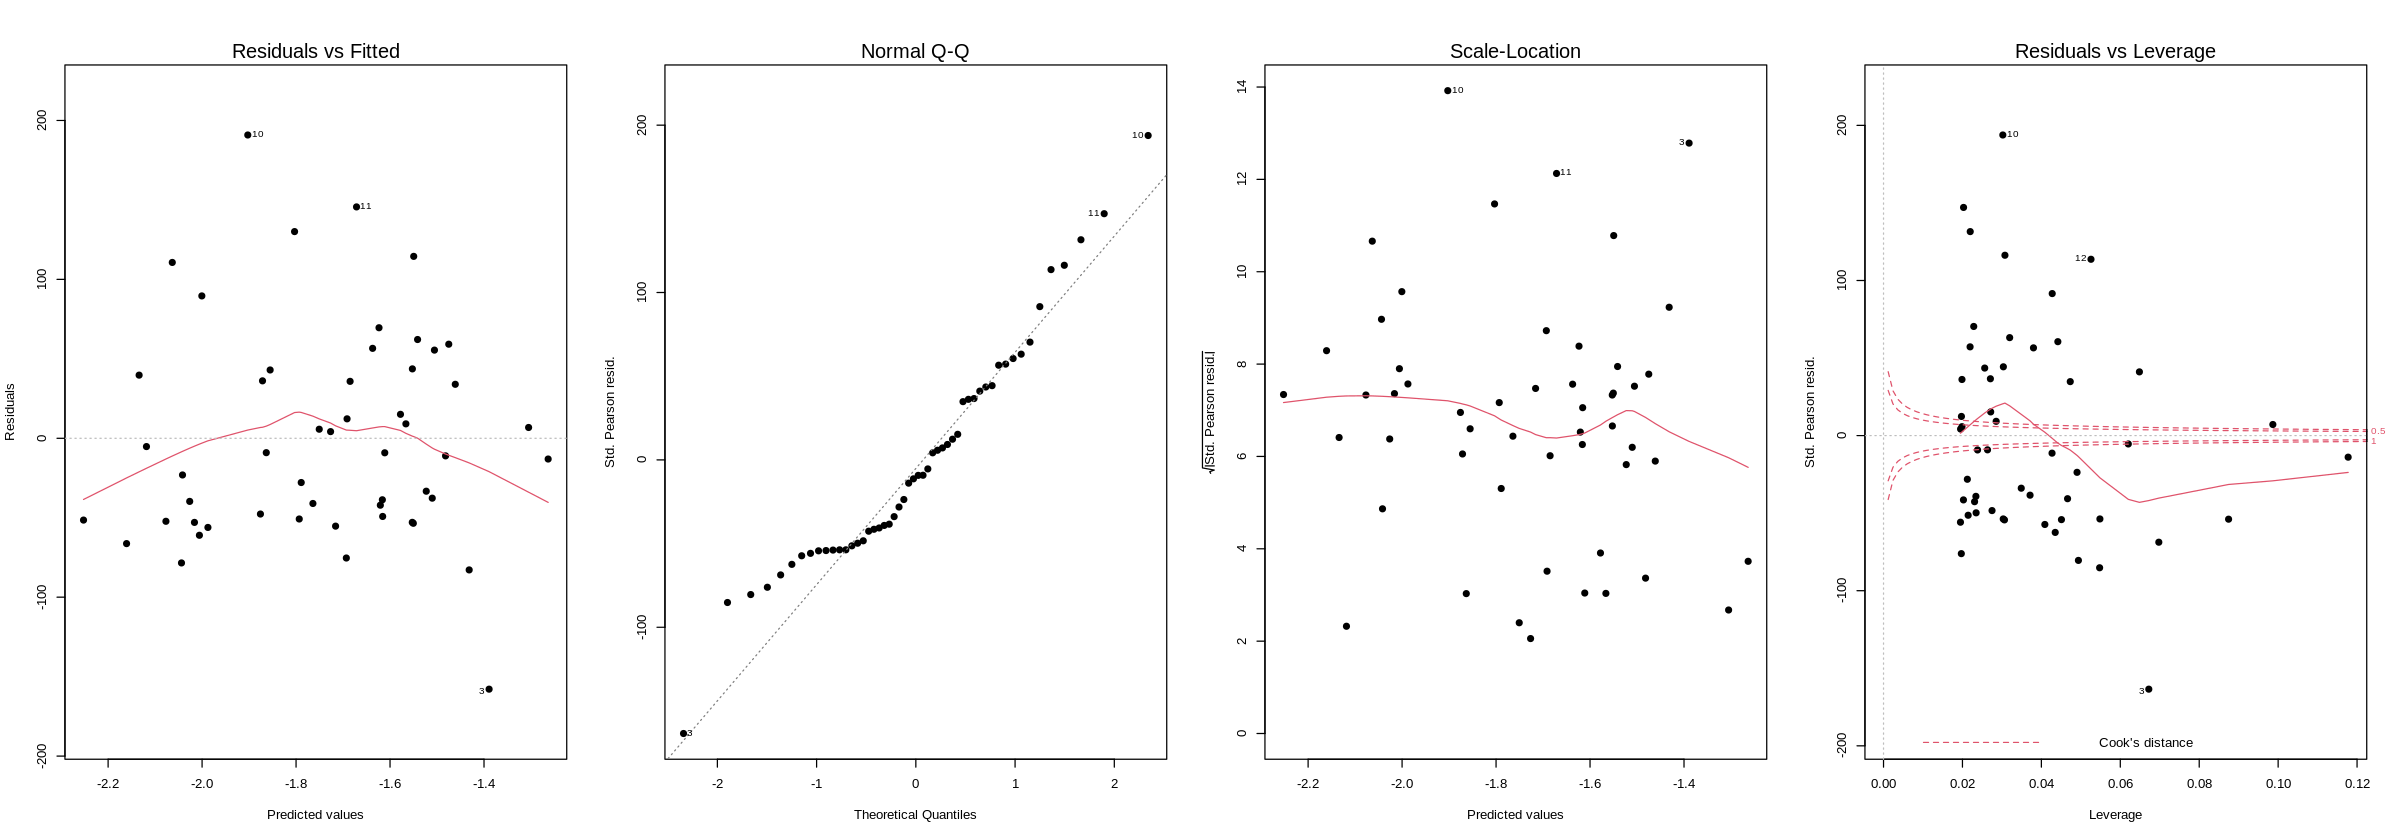

In [121]:
options(repr.plot.width=20, repr.plot.height=7)
par(mfrow=c(1,4))
plot(fit3,pch=19)

In [122]:
install.packages('betareg')
require(betareg)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [123]:
summary(d$Proportion)
sum(d$Proportion==0)
d <- transform(d, Proportion = ifelse(Proportion == 0, 0.0001, Proportion))
sum(d$Proportion==0)
head(d)[1:3,]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.08954 0.14157 0.15214 0.21372 0.33264 

[1] 1

[1] 0

,state,ICUpos,ICUneg,ICUb,IPpos,IPneg,IPb,TOTpos,TOTneg,TOTb,Proportion,stICUpos,stICUneg,stIPpos,stIPneg,stTOTpos,stTOTneg,jabsx100k,jabsperperson
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AK,35,89,123,152,931,1082,186,1019,1206,0.1543568,2823,7177,14035,85965,15436,84564,135083,1.35083
2,AR,457,547,1004,1307,5394,6701,1764,5941,7705,0.2289422,4552,5448,19505,80495,22894,77106,127641,1.27641
3,AS,0,7,7,0,75,75,0,82,82,0.0001000,0,10000,0,100000,0,100000,111404,1.11404


In [124]:
model = betareg(d$Proportion ~ scale(d$jabsx100k))
summary(model)


Call:
betareg(formula = d$Proportion ~ scale(d$jabsx100k))

Standardized weighted residuals 2:
    Min      1Q  Median      3Q     Max 
-9.2107 -0.4116  0.1764  0.6977  1.5206 

Coefficients (mean model with logit link):
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.73717    0.10412 -16.684   <2e-16 ***
scale(d$jabsx100k) -0.08676    0.09776  -0.887    0.375    

Phi coefficients (precision model with identity link):
      Estimate Std. Error z value Pr(>|z|)    
(phi)   12.908      2.531     5.1  3.4e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Type of estimator: ML (maximum likelihood)
Log-likelihood: 54.81 on 3 Df
Pseudo R-squared: 0.01154
Number of iterations: 13 (BFGS) + 1 (Fisher scoring) 

From [here](https://rcompanion.org/handbook/J_02.html):

Proportion data
In general, common parametric tests like t-test and anova shouldn’t be used when the dependent variable is proportion data, since proportion data is by its nature bound at 0 and 1, and is often not normally distributed or homoscedastic. 

 

Data of proportions, percentages, and rates can be thought of as falling into a few different categories.

 

Proportion data of discrete counts
Some proportion data is derived from discrete counts of “successes” and “failures”, where the “successes” are divided by the total counts.  The example below with passing and failing counts across classes is an example of this.  Each observation is a percentage from 0 to 100%, or a proportion from 0 to 1.  This kind of data can be analyzed with beta regression or can be analyzed with logistic regression.

 

Proportion data that is inherently proportional
Other proportion data is inherently proportional, in that it’s not possible to count “successes” or “failures”, but instead is derived, for example, by dividing one continuous variable by a given denominator value.  The sodium intake example below is an example of this.  Another case of this kind of proportion data is when a proportion is assessed by subjective measurement.  For example, rating a diseased lawn subjectively on the area dead, such as “this plot is 10% dead, and this plot is 20% dead”.  Each observation is a percentage from 0 to 100%, or a proportion from 0 to 1.  This kind of data can be analyzed with beta regression.

 

Rates with different numerators and denominators
Some rates are expressed with numerators and denominators of different measurements or units.  For example, the number of cases of a disease per 100,000 people or the number of televisions per student’s home.  In these cases, the values are not limited to between 0 and 1, and beta regression is not appropriate.  

 

If the numerator can be considered a count variable, Poisson regression or other methods for count data are usually suggested.  As a complication, often the denominator varies in value.  For example, if the count is disease occurrence in a city and the denominator is the population in a city.  (Each city has a different population.)  Or if the numerator is the count of televisions in the home and the denominator is the number of students in the home.  In these cases, Poisson regression or related methods are often recommended with an offset for the value in the denominator.  These examples are not explored further here, but an example model would be


glm(Count_of_televisions ~ Independent_variable +
    offset(log(Number_of_students_in_home)),
    family="poisson",
    data=Data)

 

Now trying with a Poisson regression:

In [125]:
Poisson2 <- glm(d$TOTpos ~ scale(d$jabsx100k), offset(log(d$TOTn)), family="poisson", data=d)
summary(Poisson2)


Call:
glm(formula = d$TOTpos ~ scale(d$jabsx100k), family = "poisson", 
    data = d, weights = offset(log(d$TOTn)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-187.07  -142.55   -98.20     0.73   668.39  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        7.8154605  0.0009516 8212.73   <2e-16 ***
scale(d$jabsx100k) 0.0509110  0.0009987   50.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1672355  on 51  degrees of freedom
Residual deviance: 1669766  on 50  degrees of freedom
AIC: 1673690

Number of Fisher Scoring iterations: 6


Negative binomial:

In [126]:
install.packages('MASS')
require(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [127]:
# Negative binomial:
summary(m <- glm.nb(d$TOTpos ~ scale(d$jabsx100k)))


Call:
glm.nb(formula = d$TOTpos ~ scale(d$jabsx100k), init.theta = 0.6190222711, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1475  -1.0465  -0.5234   0.1140   2.4662  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)          7.6855     0.1763  43.598   <2e-16 ***
scale(d$jabsx100k)   0.1127     0.1780   0.633    0.527    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.619) family taken to be 1)

    Null deviance: 64.114  on 51  degrees of freedom
Residual deviance: 63.929  on 50  degrees of freedom
AIC: 900.04

Number of Fisher Scoring iterations: 1


              Theta:  0.619 
          Std. Err.:  0.104 

 2 x log-likelihood:  -894.042 

Independent of the above analysis, here is an [example online](http://sherrytowers.com/2018/03/07/logistic-binomial-regression/):

In [128]:
set.seed(541831)
vday = seq(0,2*365) # Two years
vlogit_of_p_predicted = -1 + 0.005 * vday # Linear equation of the log of the odds
vp_predicted = exp(vlogit_of_p_predicted)/(1+exp(vlogit_of_p_predicted)) # The proportion is the prediction: fraction of succ's!
head(vp_predicted)

[1] 0.2689414 0.2699256 0.2709121 0.2719008 0.2728918 0.2738850

In [129]:
num_guns_found_per_day = 10
wfound_with_round_chambered = numeric(0)
wday_gun_found = numeric(0)
for (i in 1:length(vday)){
  v = rbinom(num_guns_found_per_day,1,vp_predicted[i]) # 10 Bern trials with changing probs's for each day.
  wfound_with_round_chambered = c(wfound_with_round_chambered,v) # Every day the number is appended.
  wday_gun_found = c(wday_gun_found , rep(vday[i],num_guns_found_per_day)) # Each numbered day of 2 years is repeated 10 times.
}

In [130]:
num_aggregated_ones_per_day = aggregate(wfound_with_round_chambered, by=list(wday_gun_found),FUN="sum") # Successes per day.
num_aggregated_zeros_per_day = aggregate(1-wfound_with_round_chambered, by=list(wday_gun_found),FUN="sum") # Failures per day.

In [131]:
vday = num_aggregated_ones_per_day[[1]]
vnum_found_with_round_chambered = num_aggregated_ones_per_day[[2]]
vnum_found_without_round_chambered = num_aggregated_zeros_per_day[[2]]
vnum_found = vnum_found_with_round_chambered + vnum_found_without_round_chambered

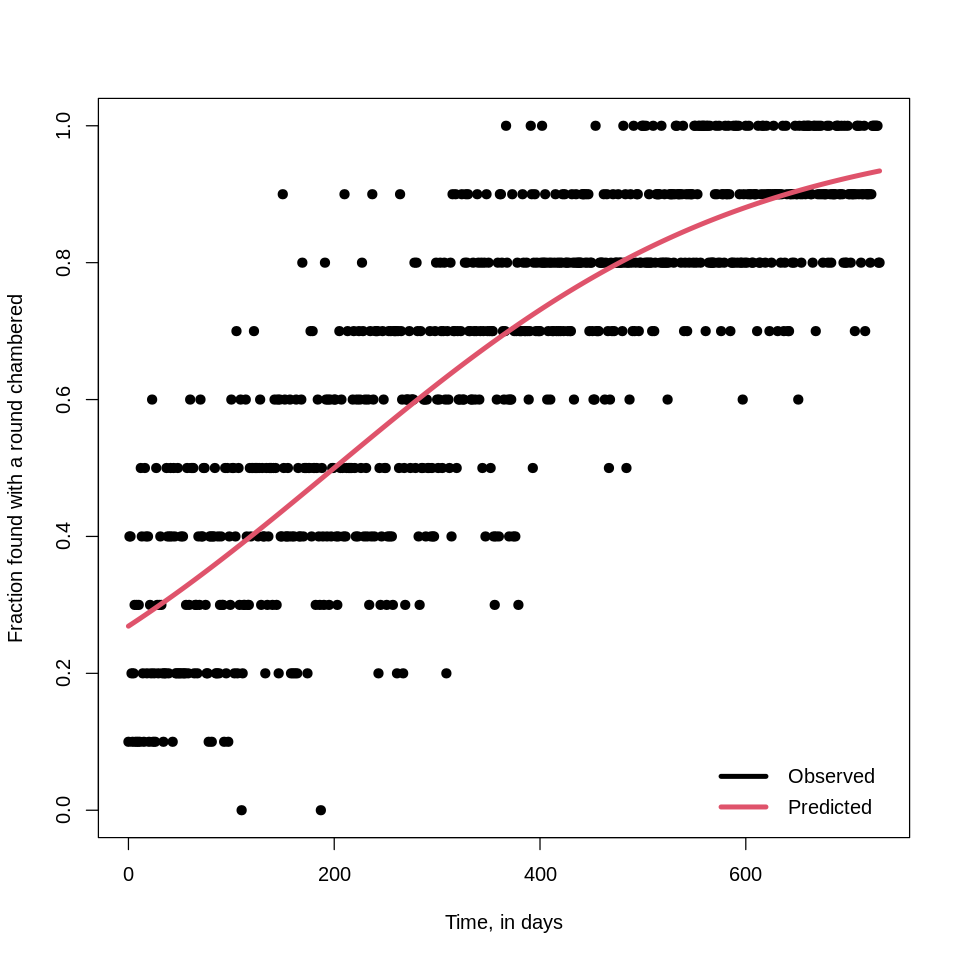

In [132]:
options(repr.plot.width=8, repr.plot.height=8)
vp_observed = vnum_found_with_round_chambered/vnum_found # Fraction observed
plot(vday, vp_observed,xlab="Time, in days",ylab="Fraction found with a round chambered",pch=19)
lines(vday, vp_predicted,lwd=4,col=2) # Fraction predicted as per the generating mechanism.
legend("bottomright",legend=c("Observed","Predicted"),col=c(1,2),lwd=4,bty="n")

In [133]:
length(vnum_found_with_round_chambered)
length(wfound_with_round_chambered)

[1] 731

[1] 7310

In [134]:
# Binomial logistic regression:
fit_to_daily_data = glm(cbind(vnum_found_with_round_chambered, vnum_found_without_round_chambered) ~ vday,family="binomial")
# Bernuilli logistic regression:
fit_to_event_data = glm(wfound_with_round_chambered ~ wday_gun_found,family="binomial")

In [135]:
print(summary(fit_to_daily_data))
print(summary(fit_to_event_data))


Call:
glm(formula = cbind(vnum_found_with_round_chambered, vnum_found_without_round_chambered) ~ 
    vday, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6263  -0.6253   0.0293   0.7733   3.0975  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.0113865  0.0520947  -19.41   <2e-16 ***
vday         0.0050202  0.0001467   34.23   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2245.8  on 730  degrees of freedom
Residual deviance:  777.3  on 729  degrees of freedom
AIC: 2397.7

Number of Fisher Scoring iterations: 4


Call:
glm(formula = wfound_with_round_chambered ~ wday_gun_found, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3330  -0.9643   0.5013   0.8286   1.6258  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)   

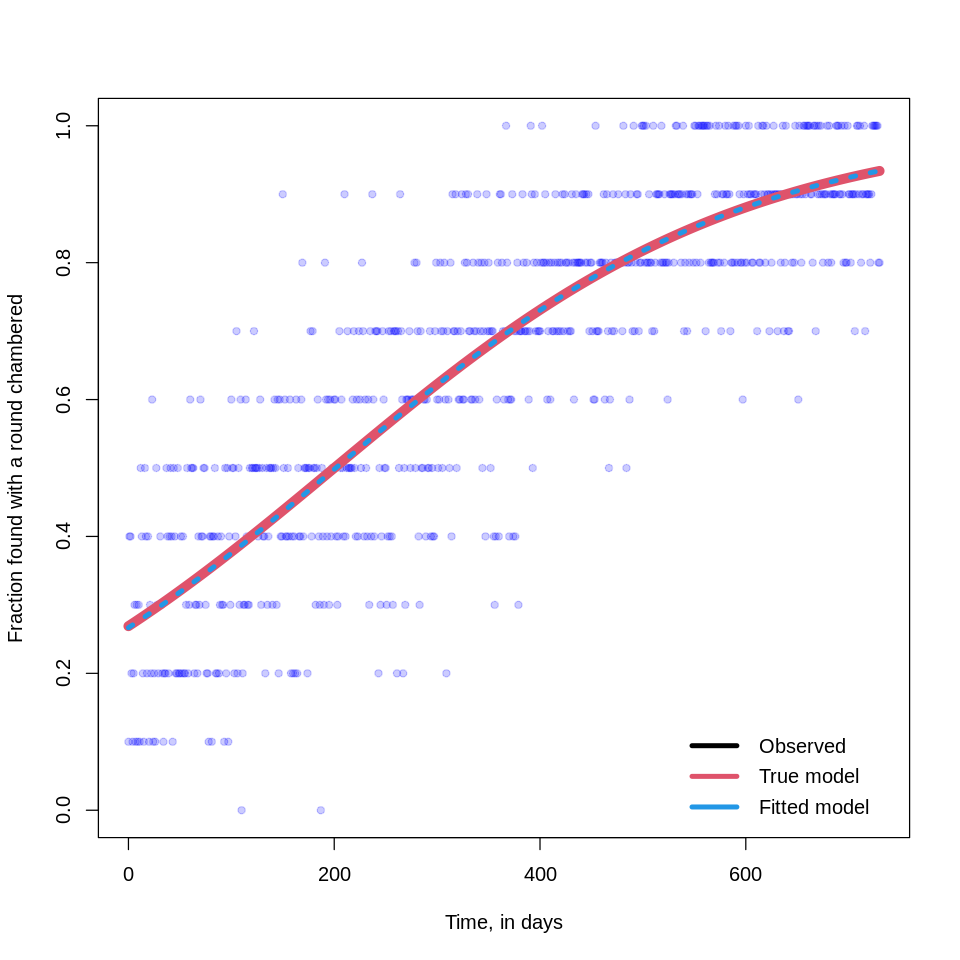

In [136]:
plot(vday,vp_observed,xlab="Time, in days",ylab="Fraction found with a round chambered", cex=.8, 
      pch=19, col=rgb(0,0,1,0.2))
lines(vday,vp_predicted,lwd=8,col=2)
lines(vday,fit_to_daily_data$fit,lwd=4,col=4,lty=3)
legend("bottomright",legend=c("Observed","True model","Fitted model"),col=c(1,2,4),lwd=4,bty="n")

Can I use the `aggregate()` function, then? No, it would be more like des-aggregate()!

In [137]:
longform <- matrix(0, sum(d$TOTpos) + sum (d$TOTneg), 2)

for (i in 1: sum (d$TOTpos)) longform[i,1] <- 1
pos <- rep(d$jabsx100k[1], d$TOTpos[1])
neg <- rep(d$jabsx100k[1], d$TOTneg[1])

for (i in 2:nrow(d)) pos <- c(pos, rep(d$jabsx100k[i], d$TOTpos[i]))
for (i in 2:nrow(d)) neg <- c(neg, rep(d$jabsx100k[i], d$TOTneg[i]))
longform[,2] <- c(pos,neg)

longform <- as.data.frame(longform)
names(longform) <- c("COVIDpos", "Vaccines")
head(longform)

,COVIDpos,Vaccines
,<dbl>,<dbl>
1,1,135083
2,1,135083
3,1,135083
4,1,135083
5,1,135083
6,1,135083


In [138]:
fitlong <- glm(longform$COVIDpos ~ longform$Vaccines, family='binomial')
summary(fitlong)
exp(cbind(OR = coef(fitlong), confint(fitlong)))


Call:
glm(formula = longform$COVIDpos ~ longform$Vaccines, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7300  -0.6501  -0.6149  -0.5863   1.9842  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.800e-01  3.929e-02  -4.582 4.61e-06 ***
longform$Vaccines -9.753e-06  2.895e-07 -33.688  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 591788  on 623745  degrees of freedom
Residual deviance: 590647  on 623744  degrees of freedom
AIC: 590651

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.8352471,0.7733373,0.9021123
longform$Vaccines,0.9999902,0.9999897,0.9999908


The coefficients are miniscule because there has to be a very large DV in relation to 1's and 0's:

In [148]:
summary(longform$Vaccines)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 103172  126565  138522  136043  143280  167941 

In [149]:
longform.st <- matrix(0, sum(d$stTOTpos) + sum (d$stTOTneg), 2)

for (i in 1: sum (d$stTOTpos)) longform.st[i,1] <- 1
pos.st <- rep(d$jabsx100k[1], d$stTOTpos[1])
neg.st <- rep(d$jabsx100k[1], d$stTOTneg[1])

for (i in 2:nrow(d)) pos.st <- c(pos.st, rep(d$jabsx100k[i], d$stTOTpos[i]))
for (i in 2:nrow(d)) neg.st <- c(neg.st, rep(d$jabsx100k[i], d$stTOTneg[i]))
longform.st[,2] <- c(pos.st,neg.st)

longform.st <- as.data.frame(longform.st)
names(longform.st) <- c("COVIDpos", "Vaccines")
head(longform.st)

,COVIDpos,Vaccines
,<dbl>,<dbl>
1,1,135083
2,1,135083
3,1,135083
4,1,135083
5,1,135083
6,1,135083


In [150]:
fitlong.st <- glm(longform.st$COVIDpos ~ longform.st$Vaccines, family='binomial')
summary(fitlong.st)
exp(cbind(OR = coef(fitlong.st), confint(fitlong.st)))


Call:
glm(formula = longform.st$COVIDpos ~ longform.st$Vaccines, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7056  -0.6159  -0.5560  -0.4890   2.1690  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.116e-01  1.075e-02   28.98   <2e-16 ***
longform.st$Vaccines -1.527e-05  8.114e-08 -188.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4434662  on 5199999  degrees of freedom
Residual deviance: 4398275  on 5199998  degrees of freedom
AIC: 4398279

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),1.3656611,1.3371772,1.3947557
longform.st$Vaccines,0.9999847,0.9999846,0.9999849


In [151]:
fitlong.st.sc <- glm(longform.st$COVIDpos ~ scale(longform.st$Vaccines), family='binomial')

In [92]:
install.packages('pROC')
install.packages('ROCR')
library(pROC)
library(ROCR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [93]:
auc(longform$COVIDpos, predict(fitlong, type="response"), quiet=T)

Area under the curve: 0.4761

In [94]:
auc(longform.st$COVIDpos, predict(fitlong.st, type="response"), quiet=T)

Area under the curve: 0.5635

In [153]:
auc(longform.st$COVIDpos, predict(fitlong.st.sc, type="response"), quiet=T)

Area under the curve: 0.5635

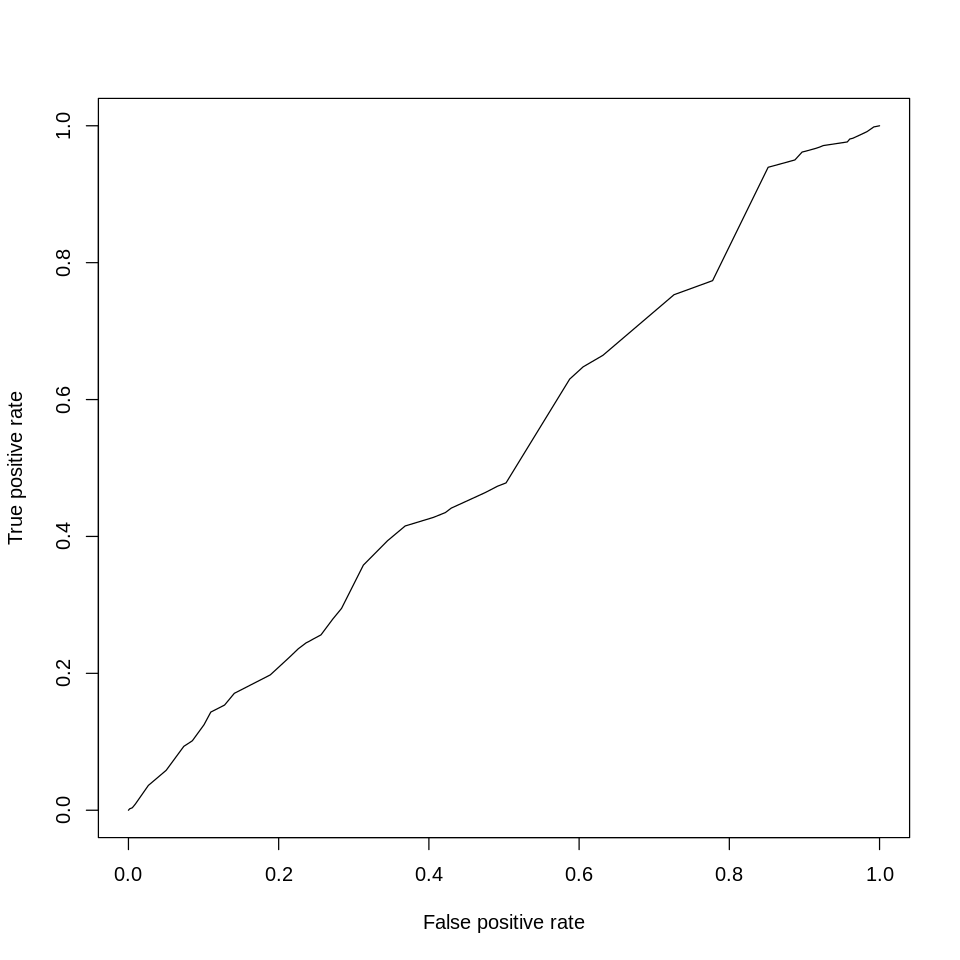

In [95]:
pr <- prediction(predict(fitlong, type="response"), longform$COVIDpos)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf)

From [this post](https://cran.rstudio.com/web/packages/ROCR/vignettes/ROCR.html):

In [162]:
head(longform)

,COVIDpos,Vaccines
,<dbl>,<dbl>
1,1,135083
2,1,135083
3,1,135083
4,1,135083
5,1,135083
6,1,135083


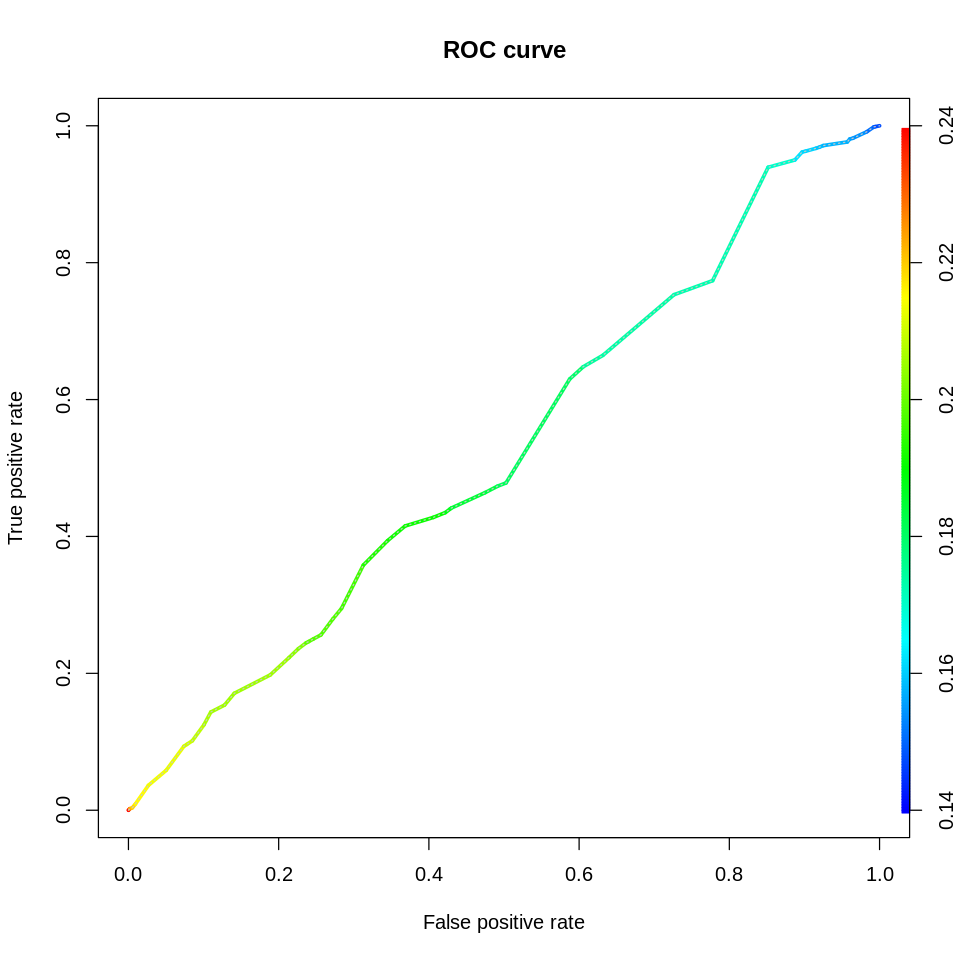

In [164]:
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf, main= 'ROC curve',
     colorize=TRUE,
     lwd= 3)
plot(prf,
     lty=3,
     col="grey78",
     add=TRUE)

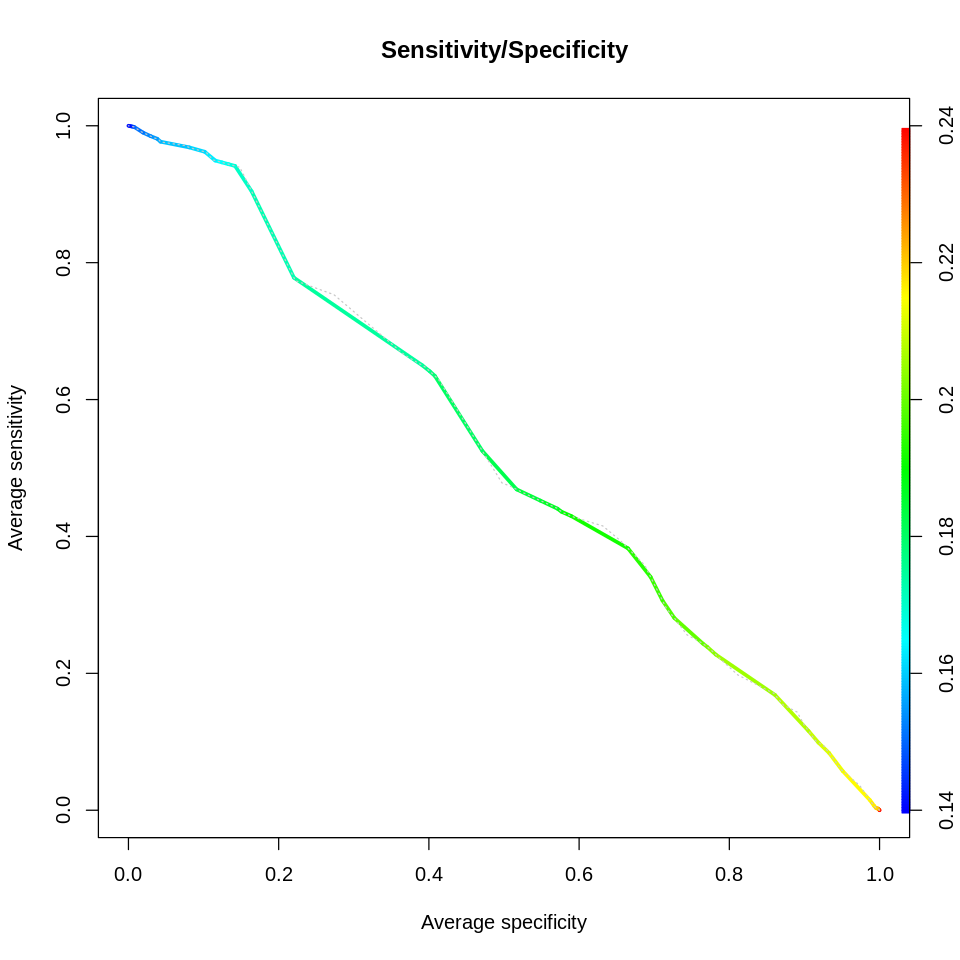

In [97]:
perf <- performance(pr, "sens", "spec")
plot(perf,
     avg= "threshold",
     colorize=TRUE,
     lwd= 3,
     main="Sensitivity/Specificity")
plot(perf,
     lty=3,
     col="grey78",
     add=TRUE)

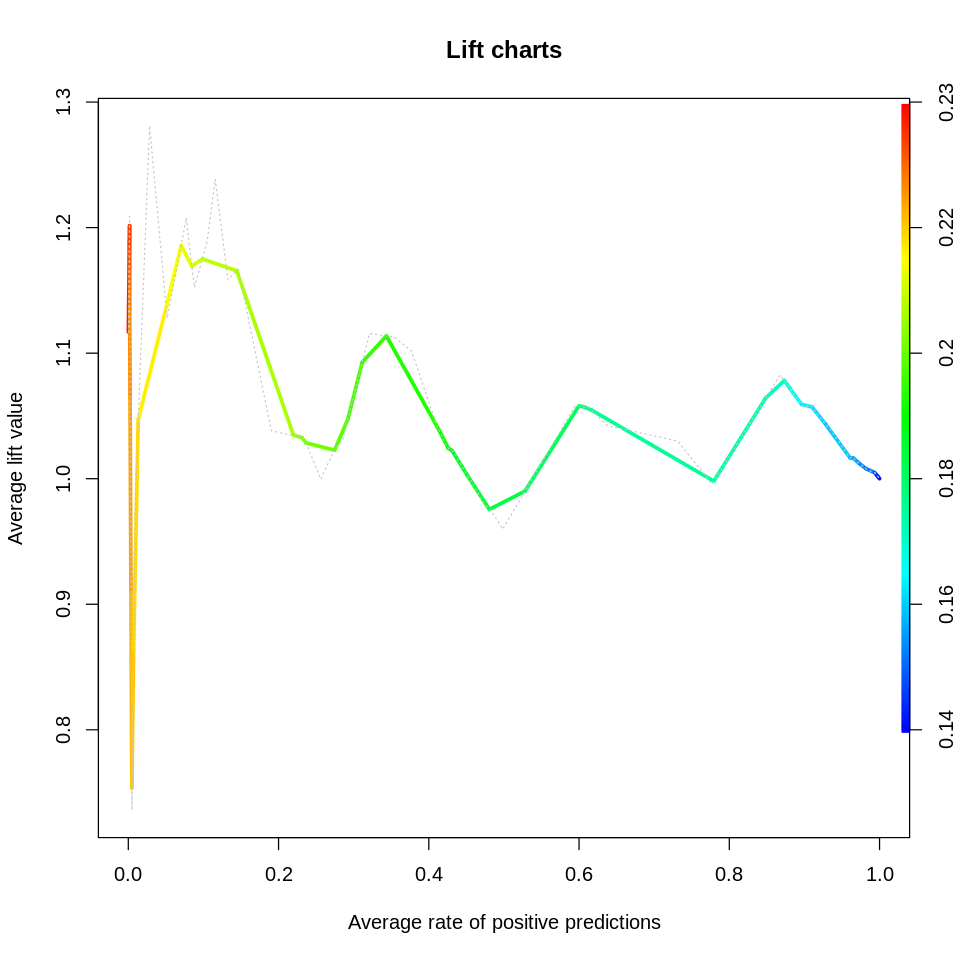

In [98]:
perf <- performance(pr, "lift", "rpp")
plot(perf,
     avg= "threshold",
     colorize=TRUE,
     lwd= 3,
     main= "Lift charts")
plot(perf,
     lty=3,
     col="grey78",
     add=TRUE)